In [ ]:
# install dependencies
!pip install dandi

In [4]:
# import packages
import json
from dandi.dandiapi import DandiAPIClient
from tqdm.notebook import tqdm
import numpy as np
from matplotlib.pyplot import *
import operator

# custom style-file for fontsizes, figuresizes etc
# style.use("styleSettings.mplstyle")


In [5]:
# initilize the DANDI client to access datasets
client = DandiAPIClient()
dandisets = list(client.get_dandisets())

In [6]:
nwb_dandisets = []

for dandiset in tqdm(dandisets): # for each data set
    raw_metadata = dandiset.get_raw_metadata() # get the metadata

    # filter for NWB data sets only
    if any(
        "NWB" in data_standard["name"]
        for data_standard in raw_metadata["assetsSummary"].get("dataStandard", [])
    ):
        nwb_dandisets.append(dandiset)

print(f"There are currently {len(nwb_dandisets)} NWB datasets on DANDI!")

  0%|          | 0/685 [00:00<?, ?it/s]

There are currently 406 NWB datasets on DANDI!


# How many dandisets exist per species?

Let's get an overview of how many data sets are uploaded for a specific species.

In [7]:
# define which species we're interested in
chosen_species = ['mouse', 'rat', 'human', 'monkey', 'fish', 'elegans', 'fly', 'rabbit', 'ant']
dandiset_species = {s:[] for s in chosen_species}

for dandiset in tqdm(nwb_dandisets):
    raw_metadata = dandiset.get_raw_metadata() # get metadata of each data set
    # try:
    #     print(raw_metadata["assetsSummary"]['species'][0]['name']) # check species names for intuition
    # except:
    #     continue
    for specie in chosen_species: # loop over species
        # append to list if data set is about the species in question
        if any(
            specie in species["name"].lower()
            for species in raw_metadata["assetsSummary"].get("species", [])
        ):
            dandiset_species[specie].append(raw_metadata['identifier'])

# combine the two zebrafish names (sometimes names zebrafish, cometimes C. elegans)
dandiset_species['fish'] = np.append(dandiset_species['fish'], dandiset_species['elegans'])
dandiset_species.pop('elegans')
chosen_species.remove('elegans')

print(f"Chosen species account for {np.sum([len(dandiset_species[s]) for s in chosen_species])} NWB datasets on DANDI.")

  0%|          | 0/406 [00:00<?, ?it/s]

Chosen species account for 380 NWB datasets on DANDI.


Text(0, 0.5, '# of DANDI sets')

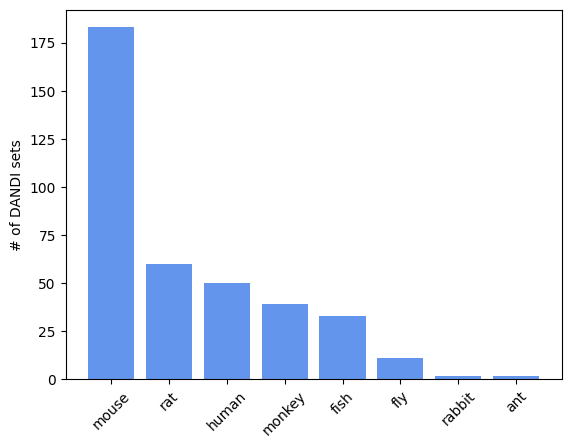

In [8]:
# get number of DANDISETS per species and sort by number of data sets
num_species = {s: len(dandiset_species[s]) for s in chosen_species}
num_species = dict(sorted(num_species.items(), key=lambda item: item[1], reverse=True))

figure()
for s_id, s in enumerate(num_species.keys()):
    bar(s_id, num_species[s], color='cornflowerblue');

# name the ticks
xticks(np.arange(len(num_species)), num_species.keys(), rotation=45);
ylabel('# of DANDI sets')
# save the file if you want
#savefig('./DatasetsBySpecies')

# Which type of recordings are most often uploaded?

In [9]:
chosen_recordings = ['microscopy', 'electrophysiolog', 'two-photon', 'one-photon', 'current clamp', 'voltage clamp']
dandiset_recording = {r:[] for r in chosen_recordings}

for dandiset in tqdm(nwb_dandisets):
    raw_metadata = dandiset.get_raw_metadata()
    # try: #explore the chosen names for variable techniques
    #     print(' '.join([i['name'] for i in raw_metadata["assetsSummary"]['measurementTechnique']])) # check species names
    # except:
    #     continue
    for record in chosen_recordings: # determine which of the specified techniques is used
        if record in ' '.join([i['name'] for i in raw_metadata["assetsSummary"]['measurementTechnique']]):
            dandiset_recording[record].append(raw_metadata['identifier'])

print(f"Chosen recordings account for {np.sum([len(dandiset_recording[r]) for r in chosen_recordings])} NWB datasets on DANDI.")

  0%|          | 0/406 [00:00<?, ?it/s]

Chosen recordings account for 275 NWB datasets on DANDI.


Text(0, 0.5, '# of DANDI sets')

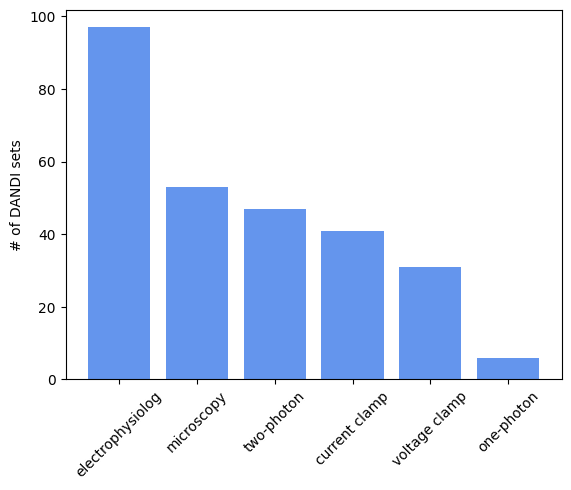

In [13]:
# get number of DANDISETS per species, sort by occurence
num_recording = {s: len(dandiset_recording[s]) for s in chosen_recordings}
num_recording = dict(sorted(num_recording.items(), key=lambda item: item[1], reverse=True))

figure()
for r_id, r in enumerate(num_recording.keys()):
  bar(r_id, num_recording[r], color="cornflowerblue")
    # TODO! plot the recording type and number of recordings similar to before

xticks(np.arange(len(num_recording)), num_recording.keys(), rotation=45);
ylabel('# of DANDI sets')
#savefig('./DatasetsByImaging')

# Let's look for a specific dataset!

Let's get more specific. We want to get the DANDI IDs to check out specific projects. Let's imagine we're interested in all mouse data sets using two-photon imaging...

In [14]:
# example: mouse + two-photon
variables = {'species': 'mouse', 'recording': 'two-photon'}

specifc_recording = []
for dandiset in tqdm(nwb_dandisets): # search all dandisets
    raw_metadata = dandiset.get_raw_metadata()

    if any(variables['species'] in species["name"].lower() for species in raw_metadata["assetsSummary"].get("species", [])) &\
                (variables['recording'] in ' '.join([i['name'] for i in raw_metadata["assetsSummary"]['measurementTechnique']])): # specify variables of interest
            specifc_recording.append(raw_metadata['identifier'])

print(f'There are {len(specifc_recording)} experiments matching: {variables} .')

  0%|          | 0/406 [00:00<?, ?it/s]

There are 29 experiments matching: {'species': 'mouse', 'recording': 'two-photon'} .


## Load one specific example experiment to explore in more depth

We can also look at the details of specific experiments. For example let's see the details to the first DANDI ID we identified using mice and two-photon imaging above to see the details of the experiments, potentially linked papers, number of subjects, etc.

In [ ]:
# get example session name
example_set = specifc_recording[0].replace('DANDI:','')
# get the associated dataset
dandiset = client.get_dandiset(example_set)
# print the belonging metadata
print(f"Example DANDI set {example_set} metadata:\n")
dandiset.get_raw_metadata()

If this approach seems too messy, you can always explore the datasets more visually on https://dandiarchive.org/ and enter the DANDI ID of interest there.\
You can also explore the dataset directly in the DANDIHUB without having to download. Also check in the dandi-notebooks folder to see if there is already an associated example notebook to get you started.